In [1]:
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
this_dir = os.path.abspath('')
# feat_dir = os.path.join(this_dir, "new_feats_13_June")

# # data_train_path = os.path.join(this_dir, "train_new_feats_2.csv")
# # data_test_path = os.path.join(this_dir, "test_new_feats_2.csv")
# data_train_path = os.path.join(feat_dir, "train_diff_feats_xyz.csv")
# data_val_path = os.path.join(feat_dir, "val_diff_feats_xyz.csv")
# data_test_path = os.path.join(feat_dir, "test_diff_feats_xyz.csv")

In [3]:
data_train = pd.read_csv('/home/tanyapohn/Documents/traffic-management/data/gen_features/checkpoint_1/train_feats.csv')


In [4]:
# data_val = pd.read_csv('/home/tanyapohn/Documents/traffic-management/data/gen_features/val_t1_feats.csv')
data_val = pd.read_csv('./df_res.csv')

In [5]:
data_train.head()

,day,time,geohash6,demand,day_mod,consec_zeros,week_day,hour,minute,mean_demand_per_hour,median_demand_per_hour,mean_demand_per_week,median_demand_per_week,mean_demand_per_geo,median_demand_per_geo,x_coord,y_coord,z_coord
0,15,00:00:00,qp02yc,0.0,15.0,0.0,1.0,0.0,0.0,0.0,0.0,0.001842,0.0,0.000393,0.0,-5.678249,497.6783,-47.79192
1,15,00:15:00,qp02yc,0.0,15.0,1.0,1.0,0.0,15.0,0.0,0.0,0.001842,0.0,0.000393,0.0,-5.678249,497.6783,-47.79192
2,15,00:30:00,qp02yc,0.0,15.0,2.0,1.0,0.0,30.0,0.0,0.0,0.001842,0.0,0.000393,0.0,-5.678249,497.6783,-47.79192
3,15,00:45:00,qp02yc,0.0,15.0,3.0,1.0,0.0,45.0,0.0,0.0,0.001842,0.0,0.000393,0.0,-5.678249,497.6783,-47.79192
4,22,00:00:00,qp02yc,0.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,0.001842,0.0,0.000393,0.0,-5.678249,497.6783,-47.79192


In [5]:
data_val.head()

,geohash6,day,demand,time,day_mod,week_day,hour,minute,consec_zeros,mean_demand_per_hour,median_demand_per_hour,mean_demand_per_week,median_demand_per_week,mean_demand_per_geo,median_demand_per_geo,x_coord,y_coord,z_coord
0,qp03nr,51,0.000293,20:45:00,20.0,2.0,20.0,45.0,1.0,0.003515,0.001619,0.095897,0.081543,0.003124,0.000177,-5.488094,497.744136,-47.123833
1,qp093r,48,0.054170,06:15:00,17.0,6.0,6.0,15.0,0.0,0.073520,0.067849,0.049256,0.048005,0.092848,0.086158,-6.633853,497.766185,-46.742031
2,qp03rp,52,0.359406,11:45:00,21.0,3.0,11.0,45.0,0.0,0.153919,0.154569,0.087696,0.080602,0.127003,0.119403,-5.774834,497.776892,-46.742031
3,qp03mf,48,0.057255,11:30:00,17.0,6.0,11.0,30.0,0.0,0.025721,0.024322,0.021948,0.020869,0.037955,0.036806,-5.297355,497.759737,-46.980661
4,qp091w,56,0.008772,10:00:00,25.0,0.0,10.0,0.0,0.0,0.037505,0.032481,0.021091,0.013350,0.031181,0.028723,-6.728751,497.724390,-47.171557


In [4]:
# data_test = pd.read_csv(data_test_path, index_col=[0])

In [6]:
data_val = data_val.fillna(0)

In [6]:
# data_test = data_test.fillna(0)

In [7]:
X_train = data_train.drop(['geohash6','time','demand', 'day'],axis=1)
y_train = data_train['demand']

X_val = data_val.drop(['geohash6','time', 'day', 'demand'],axis=1)
y_val = data_val['demand']

# X_test = data_test.drop(['geohash6','time','demand'],axis=1)
# y_test = data_test['demand']

In [8]:
X_train.columns.values

array(['day_mod', 'consec_zeros', 'week_day', 'hour', 'minute',
       'mean_demand_per_hour', 'median_demand_per_hour',
       'mean_demand_per_week', 'median_demand_per_week',
       'mean_demand_per_geo', 'median_demand_per_geo', 'x_coord',
       'y_coord', 'z_coord'], dtype=object)

In [10]:
cols =  X_train.columns.values
X_val = X_val[cols]
# data_test = data_test[cols]

In [12]:
%%time
xgb_reg = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.04, objective = 'reg:squarederror', booster ='dart')
xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_val, y_val)], 
            eval_metric = 'rmse', early_stopping_rounds=30)

/home/tanyapohn/.local/share/virtualenvs/traffic-management-vd3_-FoE/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/tanyapohn/.local/share/virtualenvs/traffic-management-vd3_-FoE/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:0.445443	validation_1-rmse:0.406827
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:0.421424	validation_1-rmse:0.39049
[2]	validation_0-rmse:0.405929	validation_1-rmse:0.374797
[3]	validation_0-rmse:0.395781	validation_1-rmse:0.359788
[4]	validation_0-rmse:0.375204	validation_1-rmse:0.345303
[5]	validation_0-rmse:0.362656	validation_1-rmse:0.33154
[6]	validation_0-rmse:0.351517	validation_1-rmse:0.318368
[7]	validation_0-rmse:0.330635	validation_1-rmse:0.305578
[8]	validation_0-rmse:0.322436	validation_1-rmse:0.293404
[9]	validation_0-rmse:0.310744	validation_1-rmse:0.2818
[10]	validation_0-rmse:0.294568	validation_1-rmse:0.270568
[11]	validation_0-rmse:0.283408	validation_1-rmse:0.259919
[12]	validation_0-rmse:0.275565	validation_1-rmse:0.249636
[13]	validation_0-rmse:0.261045	validation_1-rmse:0.239842
[14]	validation_0-rmse:0.2544

#### [99]	validation_0-rmse:0.016281	validation_1-rmse:0.0259
#### [199]	validation_0-rmse:0.015483	validation_1-rmse:0.025072	validation_2-rmse:0.025186
#### [162]	validation_0-rmse:0.015665	validation_1-rmse:0.025097

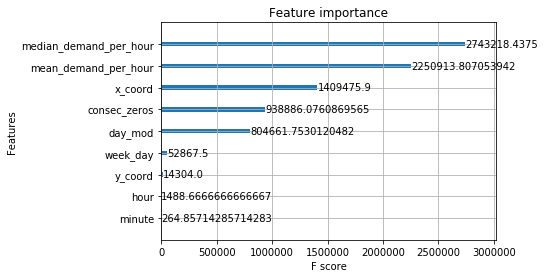

In [13]:
xgb.plot_importance(xgb_reg,importance_type='cover', max_num_features=45)
plt.show()

In [16]:
# xgb_reg.save_model(os.path.join(this_dir, "model_xgb/xgb_t_plus_1.model"))

In [18]:
y_pred = xgb_reg.predict(X_val, ntree_limit=xgb_reg.best_iteration)

In [44]:
import gc
def gen_diff_features(df: pd.DataFrame) -> pd.DataFrame:

    df = df.sort_values(by=['geohash6', 'day', 'time'])
    df = df.reset_index(drop=True)

    lag_feat = df[['day', 'time', 'geohash6', 'y_pred']].copy()
    lag_feat = lag_feat.set_index(['day', 'time', 'geohash6'])
    lag_feat = lag_feat.unstack().shift(1)  # pull out the groups, shift with lag step=1
    lag_feat = lag_feat.stack(dropna=False)
    lag_feat = lag_feat.reset_index()
    lag_feat.rename(columns={'y_pred': 'lag_demand_1'}, inplace=True)

    tmp2 = pd.merge(df, lag_feat, how='inner', on=['day', 'time', 'geohash6'])

    tmp2['lag_demand_1'] = tmp2['lag_demand_1'].fillna(0)
    series_test_lag_diff = tmp2['lag_demand_1']
    del tmp2
    gc.collect()

    roll_feat = df[['day', 'time', 'geohash6', 'y_pred']].copy()
    roll_feat = roll_feat.set_index(['day', 'time', 'geohash6'])
    roll_feat = roll_feat.unstack().rolling(3).mean()  # pull out the groups, shift with lag step=1
    roll_feat = roll_feat.stack(dropna=False)
    roll_feat = roll_feat.reset_index()
    roll_feat.rename(columns={'y_pred': 'roll_demand'}, inplace=True)

    tmp3 = pd.merge(df, roll_feat, how='inner', on=['day', 'time', 'geohash6'])
    tmp3['roll_demand'] = tmp3['roll_demand'].fillna(0)
    series_test_rolling_diff = tmp3['roll_demand']

    df['u_diff_lag'] = series_test_lag_diff - df['mean_demand_per_hour']
    df['median_diff_lag'] = series_test_lag_diff - df['median_demand_per_hour']
    # ----------------------
    df['u_diff_lag_week'] = series_test_lag_diff - df['mean_demand_per_week']
    df['median_diff_lag_week'] = series_test_lag_diff - df['median_demand_per_week']
    # ---------------------
    df['u_diff_lag_geo'] = series_test_lag_diff - df['mean_demand_per_geo']
    df['median_diff_lag_geo'] = series_test_lag_diff - df['median_demand_per_geo']
    # ----------------------
    df['u_diff_rolling'] = series_test_rolling_diff - df['mean_demand_per_hour']
    df['u_diff_rolling_week'] = series_test_rolling_diff - df['mean_demand_per_week']
    df['u_diff_rolling_geo'] = series_test_rolling_diff - df['mean_demand_per_geo']

    del tmp3, roll_feat, lag_feat
    gc.collect()

    return df

In [20]:
X_val.head()

,day_mod,consec_zeros,week_day,hour,minute,mean_demand_per_hour,median_demand_per_hour,mean_demand_per_week,median_demand_per_week,mean_demand_per_geo,median_demand_per_geo,x_coord,y_coord,z_coord
0,20.0,1.0,2.0,20.0,45.0,0.003515,0.001619,0.095897,0.081543,0.003124,0.000177,-5.488094,497.744136,-47.123833
1,17.0,0.0,6.0,6.0,15.0,0.073520,0.067849,0.049256,0.048005,0.092848,0.086158,-6.633853,497.766185,-46.742031
2,21.0,0.0,3.0,11.0,45.0,0.153919,0.154569,0.087696,0.080602,0.127003,0.119403,-5.774834,497.776892,-46.742031
3,17.0,0.0,6.0,11.0,30.0,0.025721,0.024322,0.021948,0.020869,0.037955,0.036806,-5.297355,497.759737,-46.980661
4,25.0,0.0,0.0,10.0,0.0,0.037505,0.032481,0.021091,0.013350,0.031181,0.028723,-6.728751,497.724390,-47.171557


In [21]:
y_pred_series = pd.Series(y_pred, name='y_pred')

In [45]:
df_res = pd.concat([data_val, y_pred_series], axis=1)

In [46]:
df_res.head()

,geohash6,day,demand,time,day_mod,week_day,hour,minute,consec_zeros,mean_demand_per_hour,median_demand_per_hour,mean_demand_per_week,median_demand_per_week,mean_demand_per_geo,median_demand_per_geo,x_coord,y_coord,z_coord,y_pred
0,qp03nr,51,0.000293,20:45:00,20.0,2.0,20.0,45.0,1.0,0.003515,0.001619,0.095897,0.081543,0.003124,0.000177,-5.488094,497.744136,-47.123833,0.016504
1,qp093r,48,0.054170,06:15:00,17.0,6.0,6.0,15.0,0.0,0.073520,0.067849,0.049256,0.048005,0.092848,0.086158,-6.633853,497.766185,-46.742031,0.083787
2,qp03rp,52,0.359406,11:45:00,21.0,3.0,11.0,45.0,0.0,0.153919,0.154569,0.087696,0.080602,0.127003,0.119403,-5.774834,497.776892,-46.742031,0.158180
3,qp03mf,48,0.057255,11:30:00,17.0,6.0,11.0,30.0,0.0,0.025721,0.024322,0.021948,0.020869,0.037955,0.036806,-5.297355,497.759737,-46.980661,0.040257
4,qp091w,56,0.008772,10:00:00,25.0,0.0,10.0,0.0,0.0,0.037505,0.032481,0.021091,0.013350,0.031181,0.028723,-6.728751,497.724390,-47.171557,0.050727


In [47]:
df_res = gen_diff_features(df_res)

In [48]:
df_res.head()

,geohash6,day,demand,time,day_mod,week_day,hour,minute,consec_zeros,mean_demand_per_hour,median_demand_per_hour,mean_demand_per_week,median_demand_per_week,mean_demand_per_geo,median_demand_per_geo,x_coord,y_coord,z_coord,y_pred,u_diff_lag,median_diff_lag,u_diff_lag_week,median_diff_lag_week,u_diff_lag_geo,median_diff_lag_geo,u_diff_rolling,u_diff_rolling_week,u_diff_rolling_geo
0,qp02yc,47,0.014581,03:00:00,16.0,5.0,3.0,0.0,11.0,0.001829,0.0,0.002137,0.0,0.003987,0.0,-5.678249,497.6783,-47.79192,0.016784,-0.001829,0.000000,-0.002137,0.000000,-0.003987,0.000000,-0.001829,-0.002137,-0.003987
1,qp02yc,47,0.006749,03:15:00,16.0,5.0,3.0,15.0,12.0,0.001829,0.0,0.002137,0.0,0.003987,0.0,-5.678249,497.6783,-47.79192,0.016784,0.014956,0.016784,0.014647,0.016784,0.012798,0.016784,-0.001829,-0.002137,-0.003987
2,qp02yc,47,0.009923,04:15:00,16.0,5.0,4.0,15.0,16.0,0.008423,0.0,0.002137,0.0,0.006314,0.0,-5.678249,497.6783,-47.79192,0.020441,-0.008423,0.000000,-0.002137,0.000000,-0.006314,0.000000,-0.008423,-0.002137,-0.006314
3,qp02yc,47,0.021440,04:30:00,16.0,5.0,4.0,30.0,17.0,0.008423,0.0,0.002137,0.0,0.006314,0.0,-5.678249,497.6783,-47.79192,0.020441,0.012018,0.020441,0.018304,0.020441,0.014127,0.020441,-0.008423,-0.002137,-0.006314
4,qp02yc,47,0.007095,04:45:00,16.0,5.0,4.0,45.0,18.0,0.008423,0.0,0.002137,0.0,0.006314,0.0,-5.678249,497.6783,-47.79192,0.020441,0.012018,0.020441,0.018304,0.020441,0.014127,0.020441,0.012018,0.018304,0.014127


In [49]:
df_res.to_csv('./df_res.csv', index=False)

In [24]:
location=data_val['geohash6'].unique()

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np

In [26]:
rmse_per_geo = []

In [29]:
np.mean(rmse_per_geo)

0.035801546145124125

In [191]:
# np.mean(rmse_per_geo) # with abs

0.01856225524207555

In [27]:
for i in location:
    tmp = df_res[df_res['geohash6'] == i]
    rms = sqrt(mean_squared_error(tmp['demand'], tmp['y_pred']))
    rmse_per_geo.append(rms)
    print(i+" rmse:" +str(rms))

qp03nr rmse:0.06407760804524737
qp093r rmse:0.03641775088644113
qp03rp rmse:0.04893280464635242
qp03mf rmse:0.020609075210128423
qp091w rmse:0.023044112127940948
qp0dhw rmse:0.032757723483695295
qp09fu rmse:0.04736095678675226
qp0961 rmse:0.04096684903515813
qp03zr rmse:0.018021449821804106
qp09de rmse:0.09943765788715311
qp094k rmse:0.034713655590063314
qp0d0j rmse:0.01971553014086077
qp093d rmse:0.019553370753831595
qp06nc rmse:0.017693688973426058
qp03w7 rmse:0.03791882142391588
qp03y1 rmse:0.014776645499554018
qp09k3 rmse:0.026330843782341525
qp03w0 rmse:0.032928863792620236
qp03y9 rmse:0.02838081858217088
qp03xu rmse:0.03875809597878699
qp09gw rmse:0.026536002999594518
qp09tp rmse:0.04154001435146508
qp09gy rmse:0.03095893558354584
qp08bq rmse:0.04965838735378508
qp0901 rmse:0.07256586624162581
qp03ym rmse:0.016170258849404116
qp097f rmse:0.028586167992473124
qp09fz rmse:0.04033848261403454
qp03wn rmse:0.028487080550837377
qp093u rmse:0.028571709418191846
qp098j rmse:0.14147736884

qp03xt rmse:0.121129952943485
qp09dn rmse:0.03325012977485374
qp03px rmse:0.02437178433647058
qp094w rmse:0.023124360314305467
qp09u1 rmse:0.07065850906367241
qp0dhh rmse:0.015612511506083912
qp03tt rmse:0.014871188235536792
qp03zn rmse:0.01975922098526572
qp097c rmse:0.02779217193695389
qp03rx rmse:0.02898963183112637
qp09f6 rmse:0.025962170516884167
qp0d4c rmse:0.044023629986613064
qp03tf rmse:0.019666038180235393
qp03q5 rmse:0.042651088945188
qp094h rmse:0.09155181170949594
qp0d5e rmse:0.012402967207331915
qp0djm rmse:0.02518409518460006
qp092t rmse:0.03982727695307779
qp02zx rmse:0.19561642925173156
qp099w rmse:0.020759609824826126
qp03x3 rmse:0.03553745280727093
qp09d6 rmse:0.0934661580382195
qp09t4 rmse:0.030309858210371167
qp099e rmse:0.04219483401186748
qp0d4d rmse:0.025351442714181664
qp09gr rmse:0.013398774961265333
qp03xr rmse:0.06384584713889886
qp095e rmse:0.013927467722694674
qp09th rmse:0.016838477425459516
qp03z2 rmse:0.12593634826495015
qp0dj8 rmse:0.012671601410728619

qp0932 rmse:0.015989770491344008
qp09eh rmse:0.09874959678553337
qp03rt rmse:0.05214737778714309
qp090q rmse:0.025371556378946333
qp09yh rmse:0.11532489407103676
qp09em rmse:0.045448832053242356
qp09mn rmse:0.019562561705279195
qp06p7 rmse:0.01896025125167779
qp0944 rmse:0.02778308072014198
qp0dht rmse:0.04182621489027987
qp096r rmse:0.1641677554012325
qp03qy rmse:0.11121822806868607
qp02zk rmse:0.0404045459231351
qp03qg rmse:0.13062701066523766
qp09c7 rmse:0.014162974472408692
qp09ss rmse:0.04107308420945886
qp09us rmse:0.025889903756462676
qp096y rmse:0.078425510791026
qp095z rmse:0.024160356352049
qp0d51 rmse:0.03660059583294897
qp09bw rmse:0.06735041073664248
qp02zy rmse:0.0859079497982435
qp0d4y rmse:0.017471335988245185
qp096h rmse:0.026102737695947908
qp03m2 rmse:0.016492110026901832
qp095b rmse:0.022926457514444554
qp0dh6 rmse:0.015913164456206403
qp099c rmse:0.04061941544962898
qp0d4w rmse:0.045604658608937865
qp03q8 rmse:0.02538813271045143
qp09cc rmse:0.03093469063156844
qp0

qp09v6 rmse:0.02903130837941532
qp03zq rmse:0.013201193389734226
qp09bd rmse:0.03573985847150396
qp0d4t rmse:0.03755897634329375
qp0907 rmse:0.38113032769041505
qp03xj rmse:0.11013029713793754
qp0980 rmse:0.031865533851612705
qp09y1 rmse:0.01931619441087419
qp03me rmse:0.02426240265017253
qp09tx rmse:0.042434650819988616
qp097s rmse:0.09447754367005033
qp09ee rmse:0.02195712241687968
qp09ut rmse:0.03998412380282828
qp0979 rmse:0.029355972095545725
qp03zd rmse:0.04915212857837539
qp06nt rmse:0.013839935873066063
qp03zm rmse:0.01890433804110809
qp03jr rmse:0.018981240982092872
qp09c9 rmse:0.01743615636957807
qp09uk rmse:0.023366624987439837
qp03q1 rmse:0.02442558335259081
qp09dr rmse:0.033193063864902894
qp09gb rmse:0.04126397041676587
qp09bz rmse:0.011618013307614552
qp095w rmse:0.027409737426290777
qp03y3 rmse:0.013971151752759463
qp097w rmse:0.029966076974428386
qp0d1g rmse:0.014812883059830344
qp02zc rmse:0.04456207631536577
qp097m rmse:0.04619593127512009
qp09cn rmse:0.0137939329165

qp09k5 rmse:0.01097421363633322
qp03q7 rmse:0.023140747170565548
qp08gp rmse:0.015874906763769556
qp0d1v rmse:0.012085552976923661
qp0djt rmse:0.012177337641605127
qp0d0t rmse:0.013540577473144218
qp08bs rmse:0.04237373527842779
qp08b4 rmse:0.056861927674877036
qp097x rmse:0.025878289604440587
qp099p rmse:0.012543572536360239
qp09mb rmse:0.011998853016926474
qp0906 rmse:0.06725814413681395
qp09sh rmse:0.04494570183704053
qp03rd rmse:0.02301200333002204
qp03yk rmse:0.019632971472521722
qp0d02 rmse:0.012702668970130178
qp08bn rmse:0.02332992191942766
qp03m3 rmse:0.01502706846018579
qp03t2 rmse:0.014776089672452407
qp0dje rmse:0.013296512578526305
qp09b0 rmse:0.03719778024243285
qp09vx rmse:0.02414288865757513
qp09t9 rmse:0.019390104662840576
qp0995 rmse:0.02153970454228056
qp093s rmse:0.01672341854847267
qp0dj5 rmse:0.02942533448474816
qp09dw rmse:0.013115789538320809
qp0djy rmse:0.026137263234387635
qp02z1 rmse:0.03801500546824489
qp09y0 rmse:0.011832530559353628
qp09h5 rmse:0.020595669

qp02yu rmse:0.0194752614798146
qp08gu rmse:0.013767075744354013
qp09v5 rmse:0.010440853884172407
qp09dy rmse:0.014554368410292113
qp09h6 rmse:0.011312748955547533
qp09n1 rmse:0.009438705697773744
qp09vb rmse:0.010279477336091898
qp0d43 rmse:0.010755287288340448
qp0931 rmse:0.011629362282253915
qp0d44 rmse:0.011875548290911243
qp0935 rmse:0.01165791249442264
qp08fq rmse:0.011278864666484695
qp09by rmse:0.010955970757844116
qp08gh rmse:0.012672665741811034
qp0d5s rmse:0.011076281502907724
qp09t3 rmse:0.012276721925572154
qp09w0 rmse:0.011590209994777825
qp03y5 rmse:0.014131218967289616
qp09wh rmse:0.013177650539475267
qp08cu rmse:0.013787124813494063
qp09nj rmse:0.017914791136212294
qp09s0 rmse:2.2958323133426273e-05
qp09my rmse:0.010329783595160244
qp093h rmse:0.010753752539067858
qp09n5 rmse:0.009784737951959879
qp0939 rmse:0.010383173772806412
qp09jw rmse:0.010188654779978518
qp091j rmse:0.0159707111941289
qp09qh rmse:0.01526643506834281
qp09dz rmse:0.012615855983860952
qp09m7 rmse:0.

In [30]:
df_res[df_res['geohash6'] == 'qp02yc']

,day_mod,time,geohash6,demand,y_pred
8736,27.0,02:45:00,qp02yc,0.011352,0.017687
8853,27.0,02:30:00,qp02yc,0.030095,0.017687
10424,17.0,10:30:00,qp02yc,0.046790,0.016024
27492,19.0,05:15:00,qp02yc,0.019776,0.023733
36164,19.0,07:45:00,qp02yc,0.012545,0.016024
42238,30.0,04:45:00,qp02yc,0.014507,0.019681
45999,28.0,05:15:00,qp02yc,0.008128,0.024398
49992,24.0,09:00:00,qp02yc,0.012851,0.016024
52953,29.0,09:15:00,qp02yc,0.044602,0.016381
53355,28.0,10:15:00,qp02yc,0.073735,0.016024


In [33]:
# xgb_reg.save_model(os.path.join(this_dir, "model_xgb/xgb_xyz.model"))

In [98]:
sns.set_style("darkgrid")

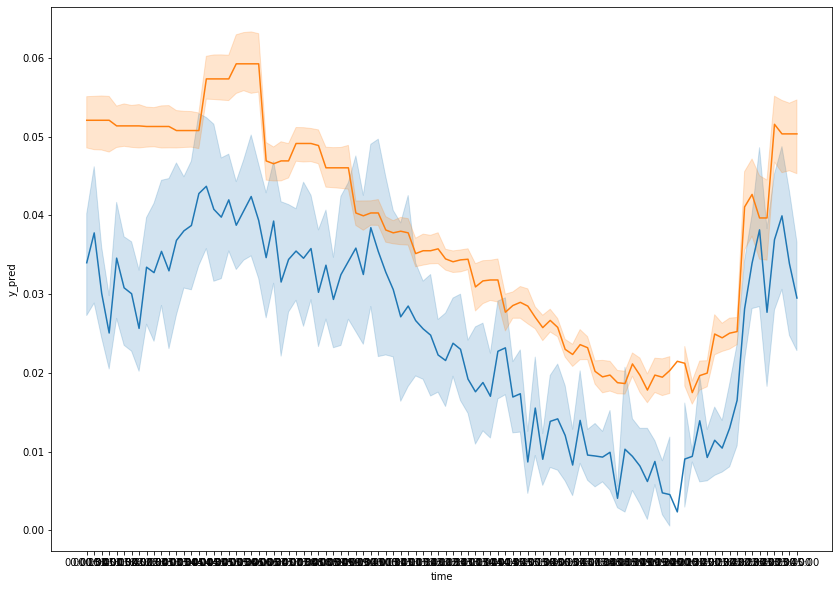

In [34]:
plt.figure(figsize=(14,10))
sns.lineplot(data=df_res[df_res['geohash6'] == 'qp03zs'], x='time', y='demand')
sns.lineplot(data=df_res[df_res['geohash6'] == 'qp03zs'], x='time', y='y_pred')